# Using Quantum circuits to generate and manipulate wavetables on SuperCollider
## Part 2 : SQPAM Y-Rotation Effect


#### This Notebook is the Part 2 continuation of the Examples with SuperCollider notebook ([part 1 here](https://quantumaudio.readthedocs.io/en/latest/supercollider1.html)) notebook. If you haven't learned how to connect Jupyter with SuperCollider please refer to the first part. To learn about the quantumaudio module, refer to the [tutorial](https://quantumaudio.readthedocs.io/en/latest/tutorial.html).

After exploring some purely "quantum loopback" effects, consisting of preparations directly succeded by measurements only, let's try to manipulate our audio in the quantum domain.


For this example, we are going to use another quantum audio scheme: SQPAM

Let's first just import the necessary libraries:

In [1]:
import numpy as np
from numpy import pi
import time
import quantumaudio as qa
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from supercollider import Server, Buffer, Synth

Similarly to part 1, we are going to use a sinusoidal table (one period of a cosine function in this case), but we won't need as many qubits for now (the simulations will take too long otherwise):

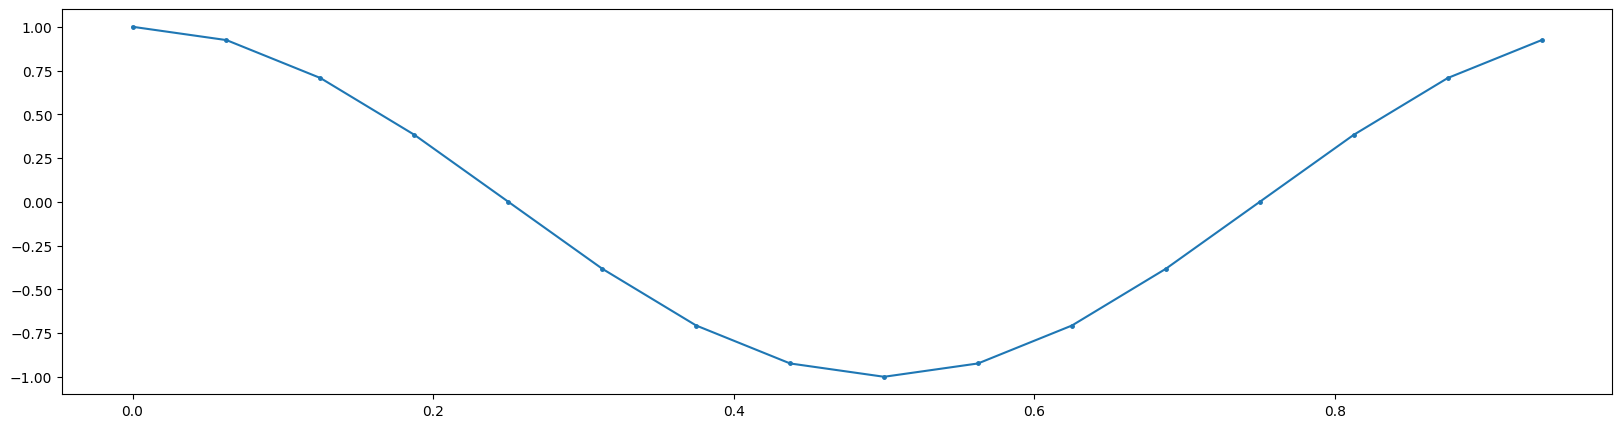

In [2]:
# Audio Sample / Table
qubit_size = 4
table_size = 2**qubit_size
t = np.linspace(0, 1-1/table_size, table_size)
sinewave = np.cos(2*np.pi*t)
plt.figure(figsize=(20,5))
plt.plot(t, sinewave, '.-', ms=5)
plt.show()

Then let's load this table in a 5-qubit SQPAM QuantumAudio object:

In [3]:
qsine = qa.QuantumAudio('sqpam').load_input(sinewave)

For this input, the SQPAM representation will require:
         4 qubits for encoding time information and 
         1 qubits for encoding ampĺitude information.


We will take advantage of our quantum audio scheme to explore some effects. The amplitudes are stored as Bloch sphere rotation angles, using controlled **$R_y$** gates. An interesting and simple idea to test would be to just *shift* all the angles (and therefore, all the amplitudes) by a certain amount:

In [4]:
def add_ry_sqpam(qa, angle, shots=10000):
    qa.prepare()
    qa.circuit.ry(angle, 0)
    qa.measure()
    qa.run(shots).reconstruct_audio()
    return qa.output

In [5]:
# This is just a convenient function to visualise what we are doing. 
def plot_out(out, color='darkblue'):
    plt.figure()
    plt.plot(out, color)
    plt.show()
    plt.close()

Then, we import the same SuperCollider functions used before to listen to the result.

In [6]:
def toWavetable(signal):
    wavetable = np.zeros(2*len(signal))
    wavetable[0::2] = 2*signal - np.roll(signal, -1)
    wavetable[1::2] = np.roll(signal, -1) - signal
    return wavetable

In [7]:
def updateBuffer (buffer, signal):
    wavetable = toWavetable(signal)
    buffer.set(wavetable)

In [8]:
server = Server()

In [9]:
b = Buffer.alloc(server, 2*len(sinewave))

In [10]:
wavetable = sinewave
updateBuffer(b, wavetable)

**Be Careful with your sound speaker/headphone volume! The default gain is set to -25dB in the line below, which is audible in many systems. Tune up the gain as necessary.**

In [11]:
synth = Synth(server, "qTable", {"buf" : b, "gain" : -25, "freq" : 250})
time.sleep(1)
synth.free()

Now, let's apply incremental **$R_y$** rotations to our audio to see how the signal changes. If you restart the `synth` again, you will be able to listen to the changes.

In this case, we will be performing 10 simulations, rotating the SQPAM audio by $\pi/10$ each time.

In [12]:
synth = Synth(server, "qTable", {"buf" : b, "gain" : -25, "freq" : 250})

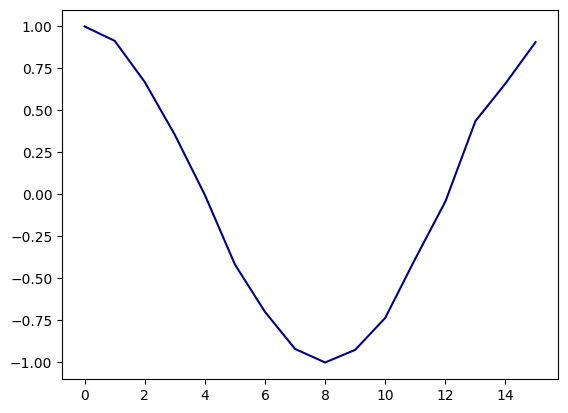

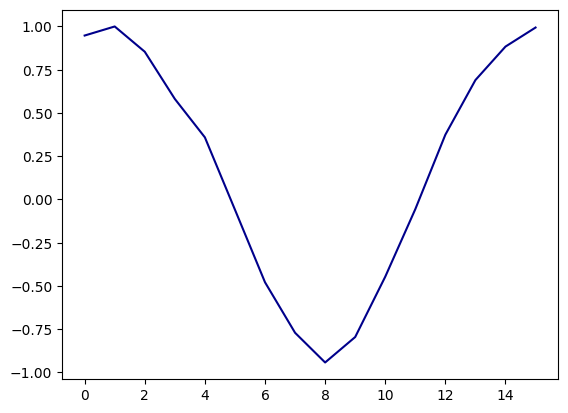

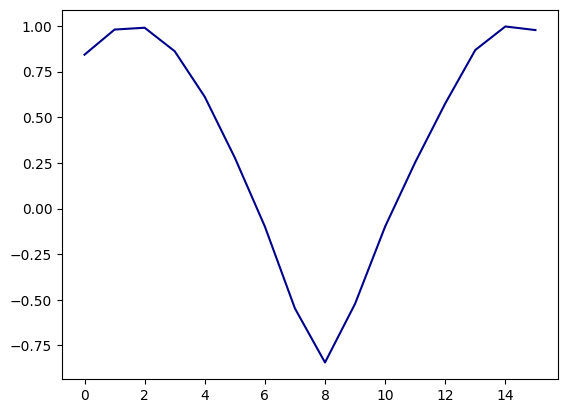

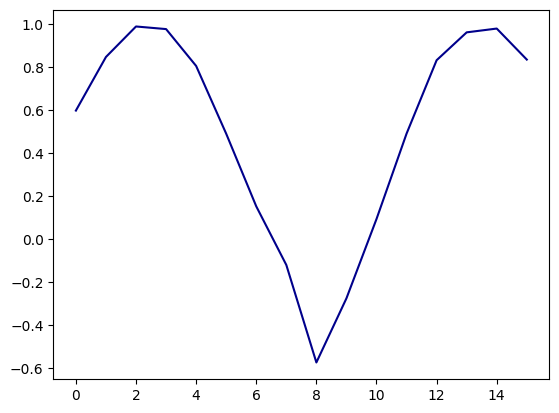

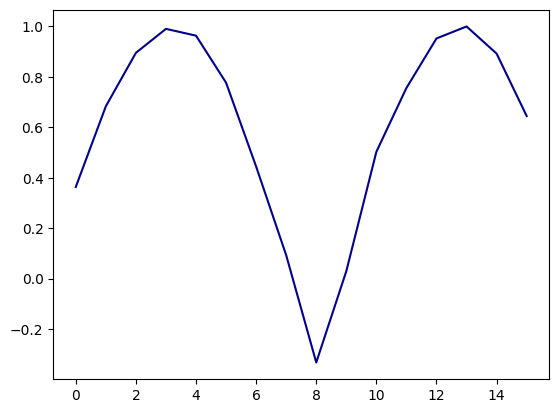

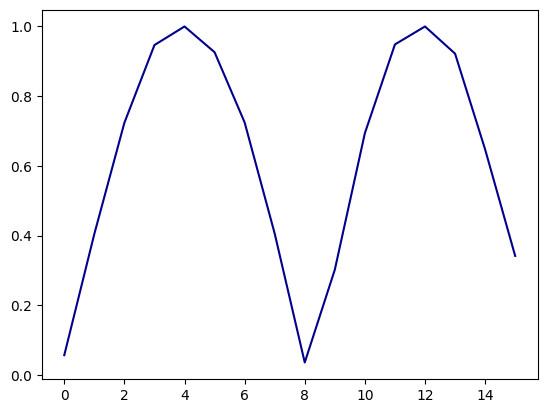

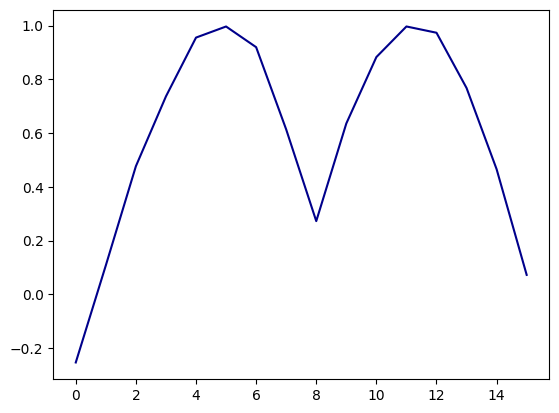

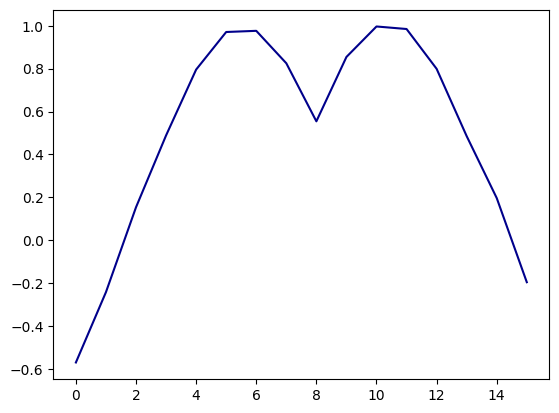

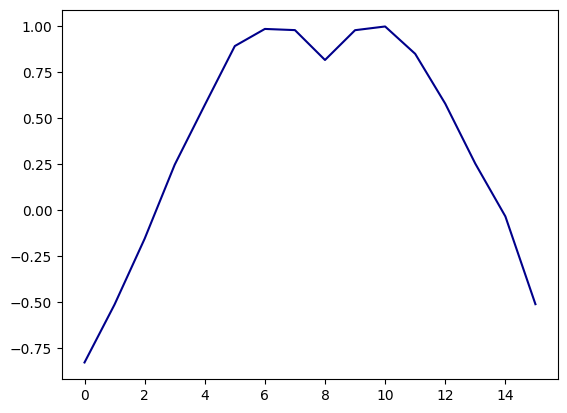

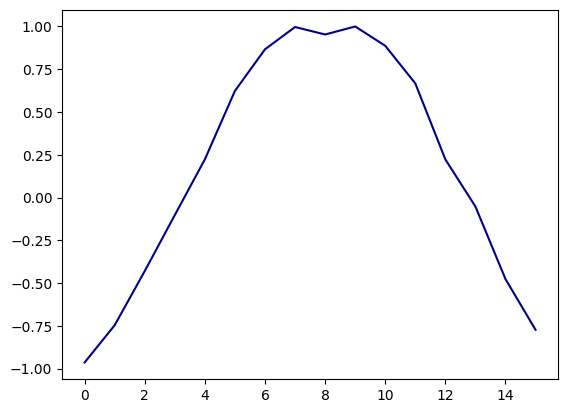

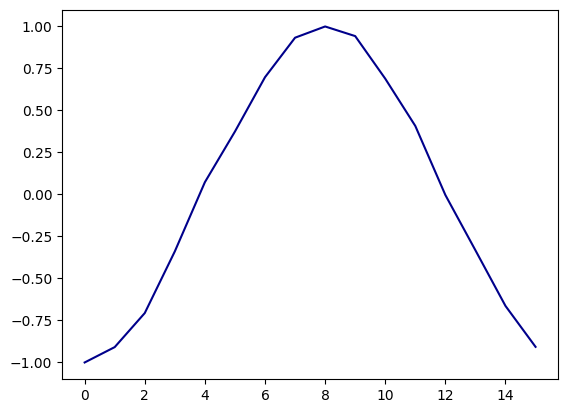

In [13]:
for i in [x*pi/10 for x in range(11)]:
    out = add_ry_sqpam(qsine, i)
    updateBuffer(b, out)
    plot_out(out)

In [14]:
synth.free()

By using controlled rotations, it is possible to apply these distortions only to a segment of the audio file. In this example, we are rotating only the second half of the signal by using the *Most Significant Qubit* as control condition

In [15]:
def add_cry_sqpam(qa, angle, control_qubit, shots=100000):
    qa.prepare()
    cry=QuantumCircuit(1)
    cry.ry(angle,0)
    qa.circuit.append(cry.to_gate().control(1), [control_qubit, 0])
    qa.measure()
    qa.circuit.draw()
    qa.run(100000).reconstruct_audio()
    return qa.output

In [16]:
synth = Synth(server, "qTable", {"buf" : b, "gain" : -25, "freq" : 250})

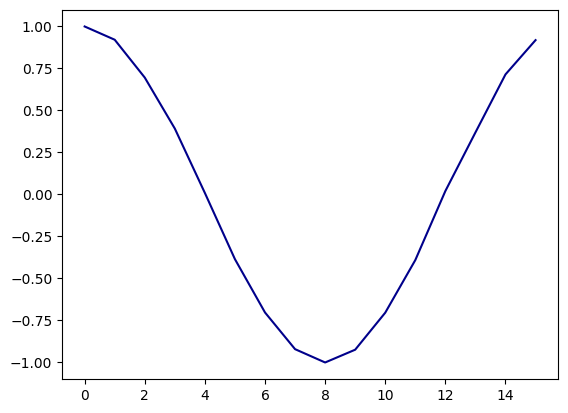

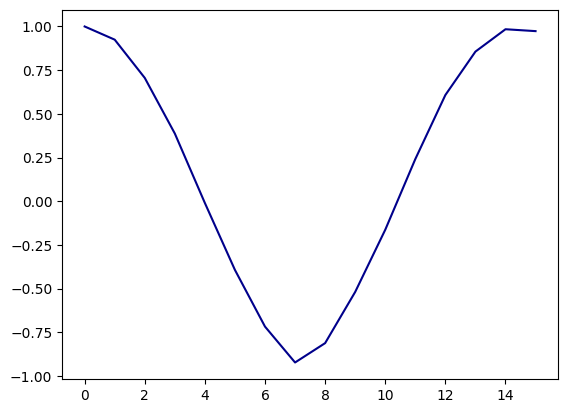

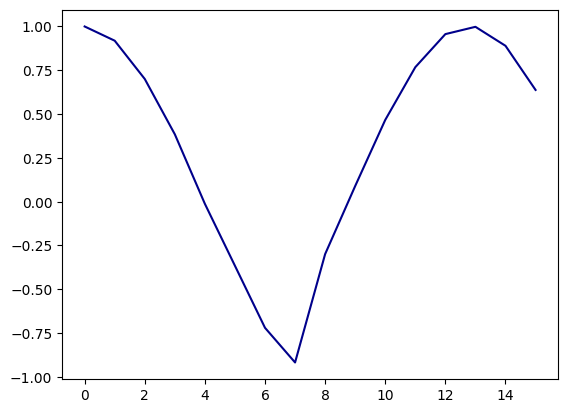

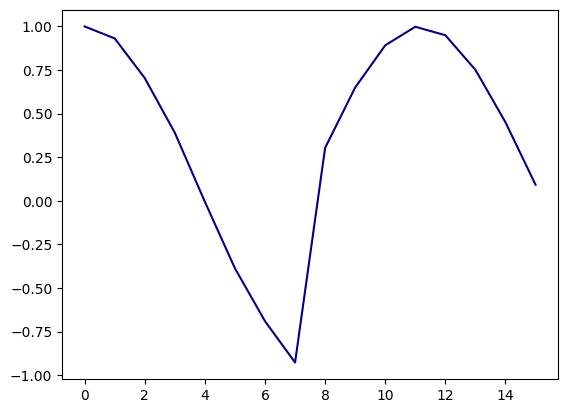

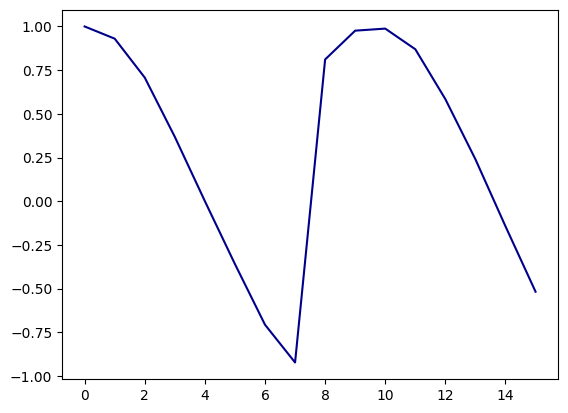

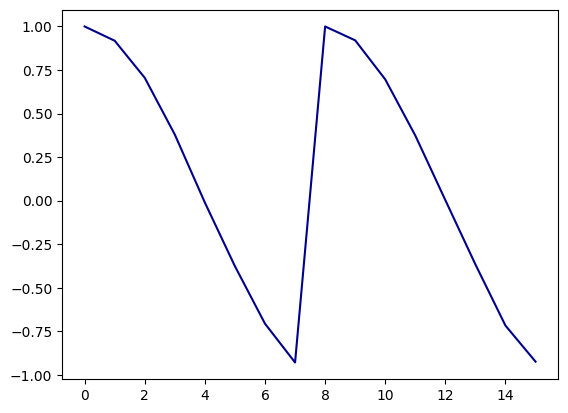

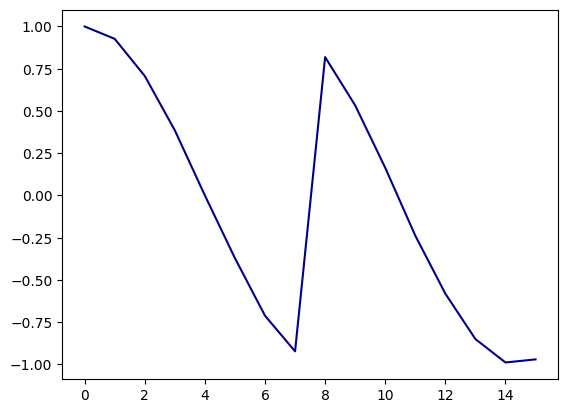

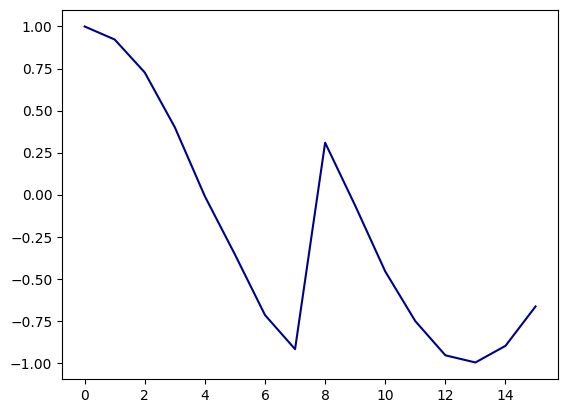

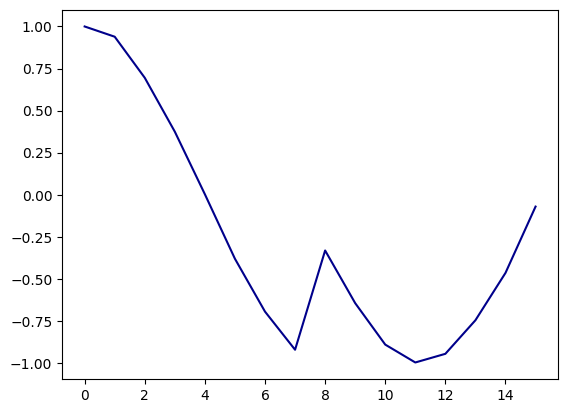

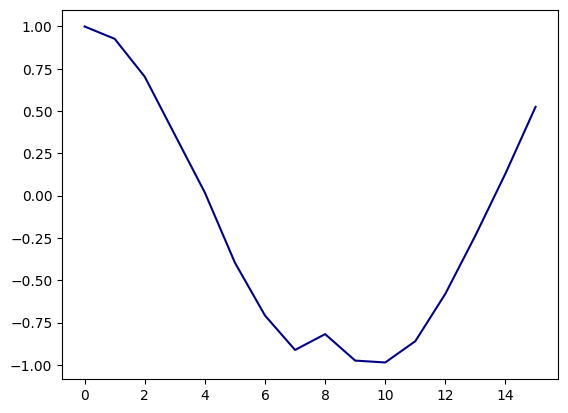

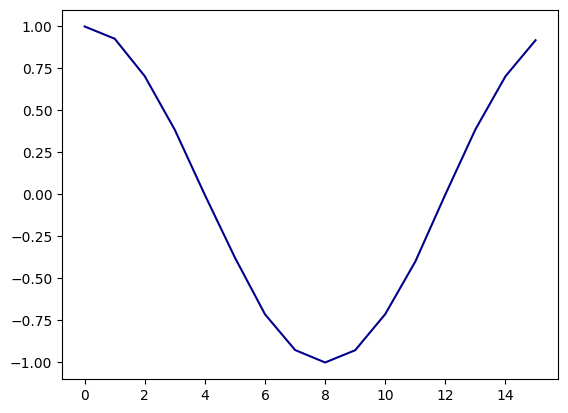

In [17]:
for i in [x*pi/5 for x in range(11)]:
    out = add_cry_sqpam(qsine, i, 4)
    updateBuffer(b, out)
    plot_out(out)

Feel free to further extrapolate and explore this idea!

In [18]:
def add_mcry_sqpam(qa, angle, shots=100000):
    qa.prepare()
    cry=QuantumCircuit(1)
    
    # Each qubit controls a rotation that is faster compared to the previous one
    cry.ry(angle,0)
    qa.circuit.append(cry.to_gate().control(1), [4, 0])
    cry.ry(angle,0)
    qa.circuit.append(cry.to_gate().control(1), [3, 0])
    cry.ry(angle,0)
    qa.circuit.append(cry.to_gate().control(1), [2, 0])
    cry.ry(angle,0)
    qa.circuit.append(cry.to_gate().control(1), [1, 0])
    
    
    qa.measure()
    qa.circuit.draw()
    qa.run(100000).reconstruct_audio()
    return qa.output

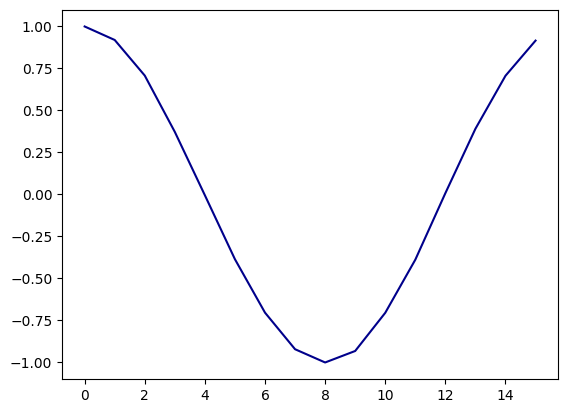

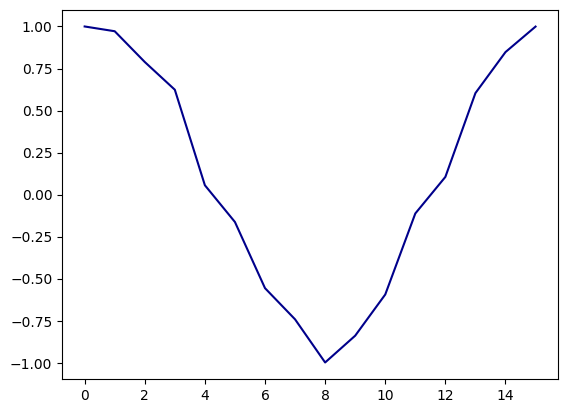

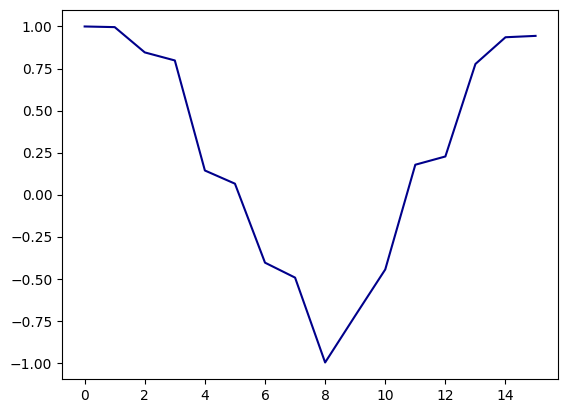

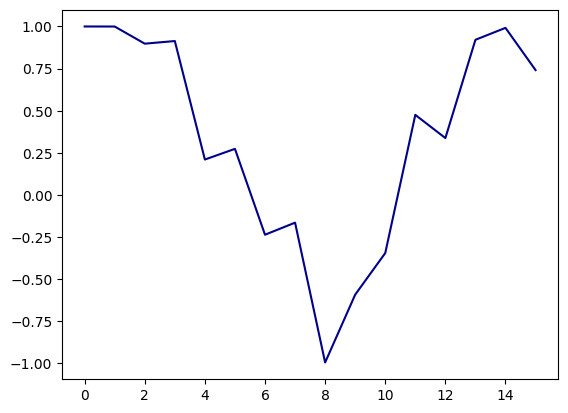

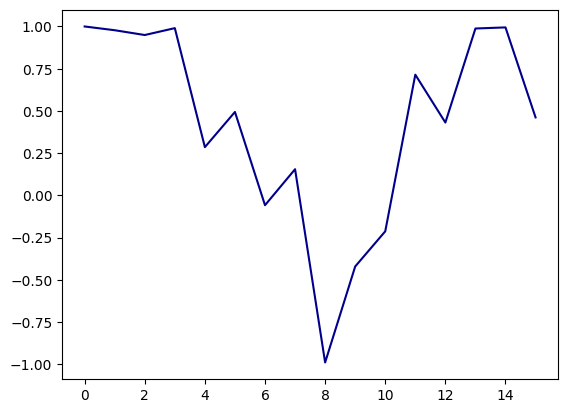

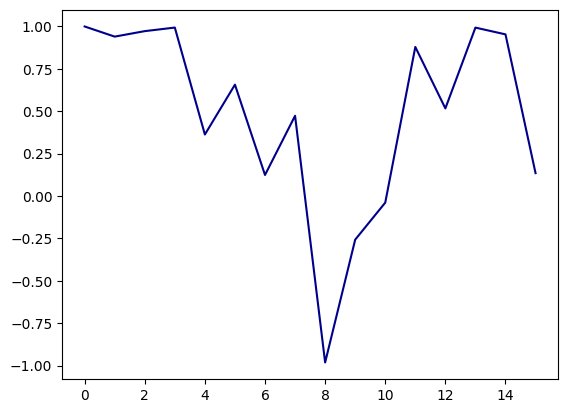

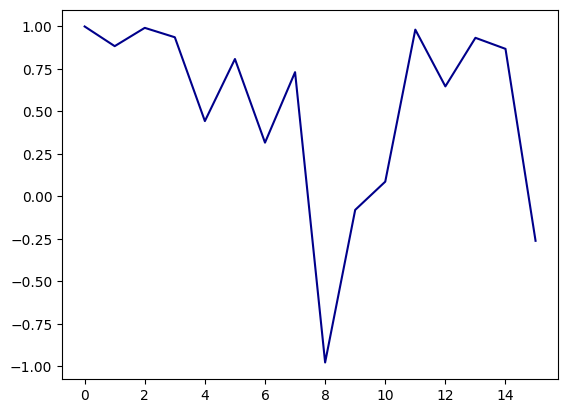

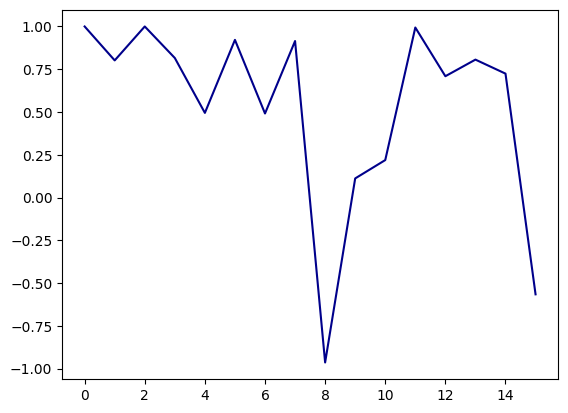

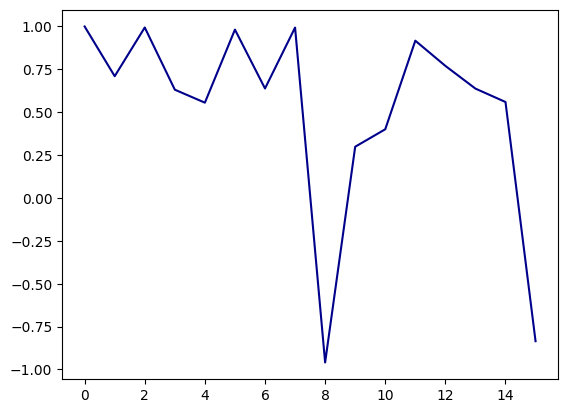

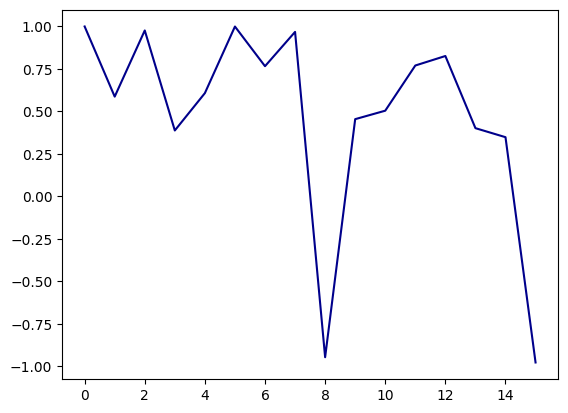

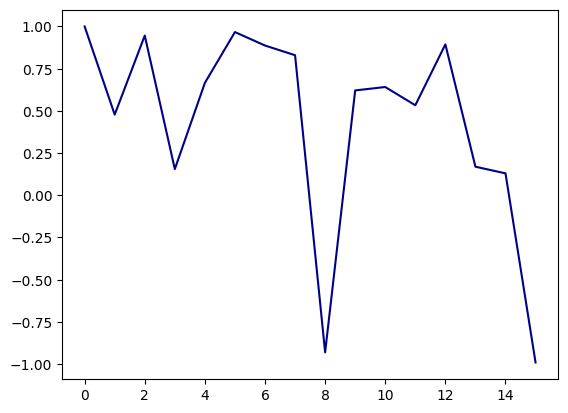

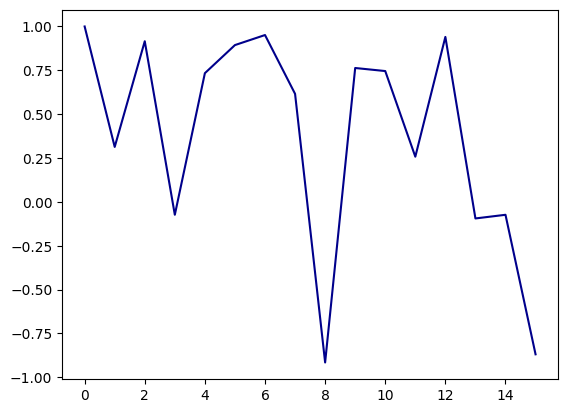

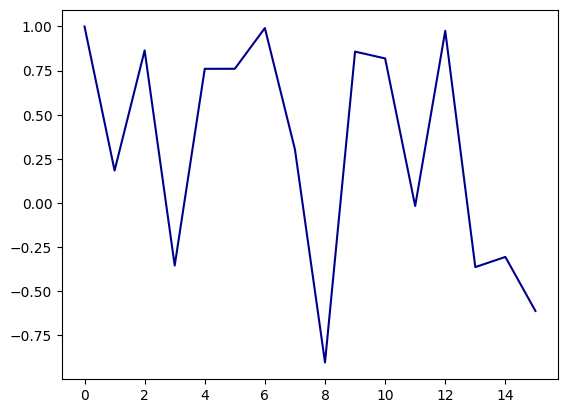

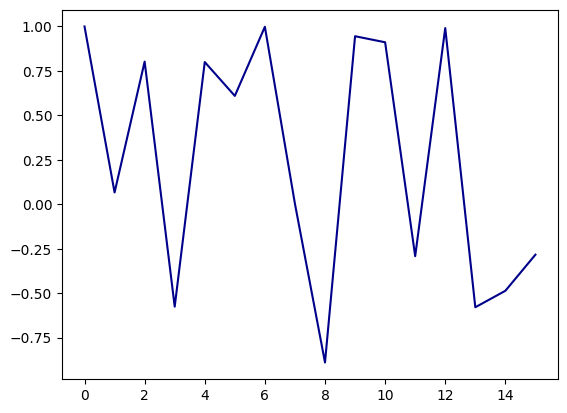

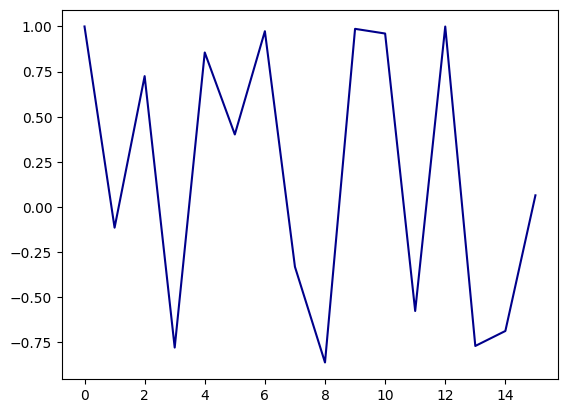

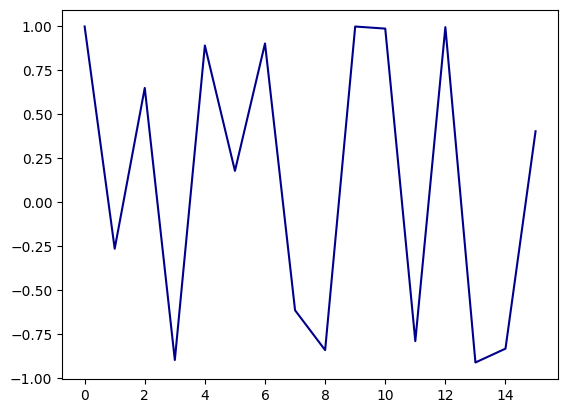

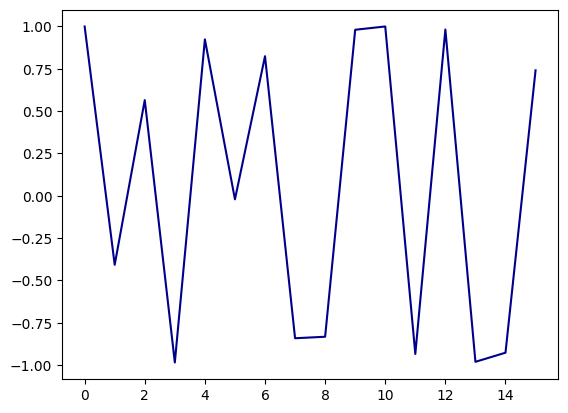

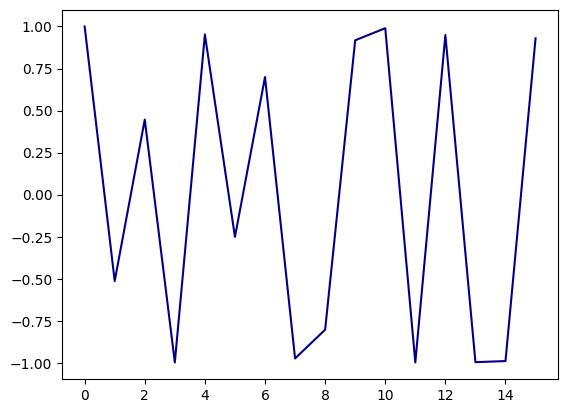

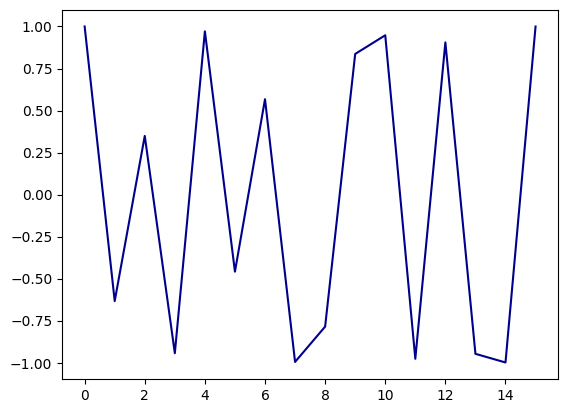

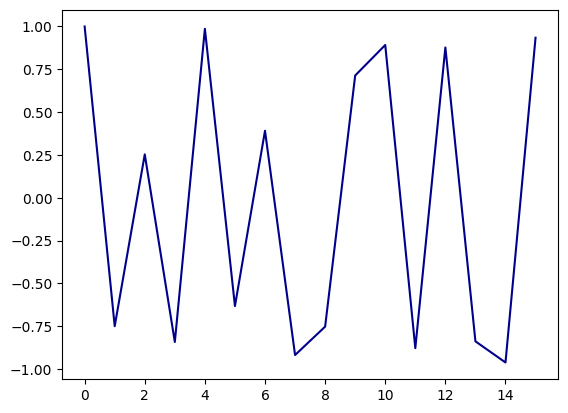

In [19]:
for i in [x*pi/85 for x in range(20)]:
    out = add_mcry_sqpam(qsine, i)
    updateBuffer(b, out)
    plot_out(out)

In [20]:
synth.free()

.

.

Download this notebook from the latest [Github release](https://github.com/iccmr-quantum/quantumaudio/releases).

Itaborala @ ICCMR Quantum https://github.com/iccmr-quantum/quantumaudio